In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
import torch
from tqdm import tqdm
import gc
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
from torch.utils.data import DataLoader
import pandas as pd
from torch.cuda.amp import GradScaler, autocast

import sys
sys.path.append("../src")
from utils import simple_mean_average_precision, StrawberryDataset, collate_fn, get_transform, get_model, load_data, get_optimizer, imshow

# Set up the dataset and data loader
train_dir = "../strawberry/train/"
val_dir = "../strawberry/val/"
test_dir = "../strawberry/test/"

train_images, df_train_labels = load_data(train_dir, 10)
test_images, df_test_labels = load_data(val_dir, 10)
val_images, df_val_labels = load_data(test_dir, 10)

batch_size = 2

train_data = StrawberryDataset(train_images, df_train_labels, transforms=get_transform)
val_data = StrawberryDataset(test_images, df_test_labels, transforms=get_transform)
test_data = StrawberryDataset(val_images, df_val_labels, transforms=get_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

cuda


  1%|▏         | 10/743 [00:00<00:00, 1102.37it/s]


## Visualize Pytorch input images

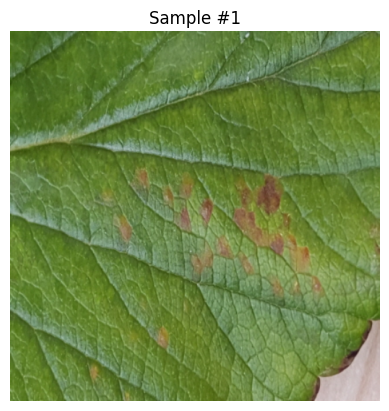

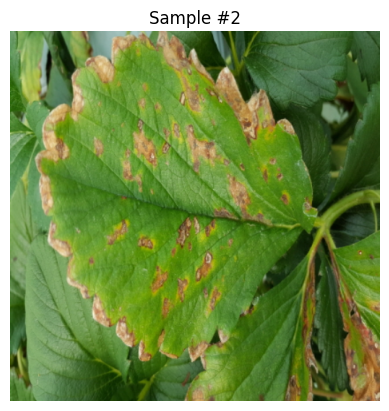

In [2]:
images, targets = next(iter(train_loader))

for i in range(len(images)):
    np_img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(np_img)
    plt.title(f'Sample #{i+1}')
    plt.axis('off')
    plt.show()

In [4]:
num_classes = 7  # Your dataset has 7 classes (labels range from 0 to 6)
model = get_model("baseline", num_classes)
model.to(device)

# Set up the optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
model, optimizer = get_optimizer("SGD", model, lr=0.0001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = GradScaler()
num_epochs = 50
history = pd.DataFrame(columns=["Epoch", "Train Loss", "Val Loss", "Train mAP"])
for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0
    train_mAP = 0
    total_train_samples = 0
    step = 0
    
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()
    
    for images, targets in tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{num_epochs}"):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        running_loss += losses.cpu().detach().item()

        total_train_samples += len(targets)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        step += 1

    model.eval()
    val_loss = 0
    val_mAP = []
    total_val_samples = 0
    predictions = []
    mAP_sums = {}

    with torch.no_grad():
        for images, targets in tqdm(train_loader, desc=f"Calculating Train mAP"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast():
                predictions = model(images)

            print("targets: ", targets)
            print("pred: ", predictions)
            mAP_dict = simple_mean_average_precision(targets, predictions)
            for key, value in mAP_dict.items():
                if key in mAP_sums:
                    mAP_sums[key] += value.cpu().detach().numpy()
                else:
                    mAP_sums[key] = value.numpy()

            total_val_samples += len(targets)

    # Calculate the average of each mAP metric
    mAP_averages = {key: value / total_val_samples for key, value in mAP_sums.items()}
    val_mAP.append(mAP_averages)

    train_loss = running_loss / (step + 1)
    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss}, Train mAP: {mAP_averages}")
    # Append the current epoch results to the history DataFrame
    history_df = pd.DataFrame(data= {
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train mAP": val_mAP
    })
    history = pd.concat([history, history_df], ignore_index=True)
    
history.to_csv("../models/training_history_test.csv", index=False)
torch.save(model.state_dict(), "../models/mask_rcnn_strawberry_test.pth")

# Evaluate the model on the test set
model.eval()
test_mAP = []
total_test_samples = 0
predictions_test = []
mAP_test_sums = {}
with torch.no_grad():
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast():
            predictions += model(images)  # Get predictions
            mAP_dict = simple_mean_average_precision(targets, predictions)

            # Update the running sum of each mAP metric
            for key, value in mAP_dict.items():
                if key in mAP_test_sums:
                    mAP_test_sums[key] += value.cpu().detach().numpy()
                else:
                    mAP_test_sums[key] = value.cpu().detach().numpy()

            total_test_samples += len(targets)

    # Calculate the average of each mAP metric
    mAP_test_averages = {key: value / total_val_samples for key, value in mAP_test_sums.items()}
    print(f"Test mAP: {mAP_test_averages}")

print("Finished evaluating the model on the test set.")

/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/Documents/dlbs_fs23/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/Documents/dlbs_fs23/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:01,  4.62it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], devi

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  4.80it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], devi

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  4.73it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscro

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscr

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.00it/s]

[{'boxes': tensor([[1.7101e+02, 3.5972e+02, 1.7875e+02, 3.7244e+02],
        [2.4949e+02, 3.4664e+02, 2.7115e+02, 3.7208e+02],
        [1.6788e+02, 3.5744e+02, 1.7676e+02, 3.7216e+02],
        [1.6860e+02, 3.6142e+02, 1.7732e+02, 3.7906e+02],
        [1.3713e+02, 3.3595e+02, 1.5087e+02, 3.5461e+02],
        [2.4388e+02, 3.3820e+02, 2.7900e+02, 3.7796e+02],
        [3.3402e+00, 1.3230e+02, 3.1520e+01, 1.9986e+02],
        [2.4925e+02, 3.5601e+02, 2.6883e+02, 3.7743e+02],
        [9.1650e-01, 4.5588e+00, 3.0603e+01, 2.1624e+02],
        [3.2687e+02, 3.0303e+02, 3.6753e+02, 3.5169e+02],
        [4.5487e+02, 2.3763e+02, 5.0385e+02, 2.8973e+02],
        [4.5157e+00, 2.1789e+01, 4.6844e+01, 2.5757e+02],
        [1.8996e+02, 4.0379e+02, 2.5132e+02, 5.0373e+02],
        [1.1824e+01, 1.1719e+02, 3.8656e+01, 2.0489e+02],
        [1.8700e+02, 2.9944e+02, 2.2388e+02, 3.4216e+02],
        [2.0361e+00, 1.7321e+02, 4.8324e+01, 3.6599e+02],
        [1.6866e+02, 4.1263e+02, 2.0126e+02, 4.8529e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.23it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], dev

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]

[{'boxes': tensor([[1.8864e+02, 1.4145e+02, 2.3696e+02, 1.8783e+02],
        [2.0615e+02, 2.9803e-01, 2.5209e+02, 4.2462e+01],
        [1.2336e+02, 2.3086e+02, 1.7136e+02, 2.7474e+02],
        [6.6122e+00, 2.3530e+02, 6.2228e+01, 4.1142e+02],
        [1.8004e+02, 1.2516e+02, 2.5164e+02, 1.8988e+02],
        [2.8290e+02, 4.2554e+02, 3.7086e+02, 4.9990e+02],
        [1.9267e+02, 0.0000e+00, 3.1485e+02, 4.5437e+01],
        [2.4115e+02, 2.6305e+02, 2.6925e+02, 3.0015e+02],
        [1.9867e+02, 5.7790e+00, 2.3269e+02, 4.2221e+01],
        [3.1418e+02, 1.7498e+02, 3.3446e+02, 1.9622e+02],
        [2.2336e+02, 2.8763e+01, 2.9600e+02, 1.0092e+02],
        [2.1830e+02, 1.9397e+02, 2.2586e+02, 2.0347e+02],
        [1.5364e+02, 1.3961e+02, 2.0092e+02, 1.8935e+02],
        [4.1890e+01, 2.3808e+02, 7.3390e+01, 3.0464e+02],
        [1.2895e+02, 1.6427e+02, 2.9505e+02, 2.2357e+02],
        [3.5669e+01, 2.1091e+02, 8.9371e+01, 3.3885e+02],
        [2.1553e+00, 0.0000e+00, 3.8665e+01, 2.4193e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.39it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscr

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.45it/s]

[{'boxes': tensor([[312.5453, 241.2968, 347.9347, 284.7832],
        [360.9958, 342.5106, 380.1241, 367.2494],
        [210.6532, 214.5430, 227.7467, 238.2570],
        [351.4550, 224.7719, 377.5050, 253.6281],
        [396.1904, 294.4496, 416.6096, 322.1903],
        [367.7029, 248.5776, 388.1371, 273.0224],
        [392.3100, 303.2767, 429.4500, 377.6833],
        [210.0597, 204.4003, 243.0602, 241.3597],
        [ 10.5136,   0.0000, 142.7664, 139.1716],
        [354.2484, 241.3624, 391.9916, 279.9176],
        [  6.1766, 376.5897,  71.7434, 504.6903],
        [249.9747, 307.9321, 268.1053, 327.5879],
        [284.2163, 280.2760, 305.2237, 305.0040],
        [314.5528, 214.4530, 335.3672, 239.9470],
        [389.9987, 274.0681, 418.9613, 331.3719],
        [378.4091, 252.2965, 389.5909, 275.0635],
        [382.1189, 327.3201, 408.9211, 376.0398],
        [384.3241, 342.9381, 401.5959, 363.6219],
        [220.6530, 208.9985, 264.4670, 258.2015],
        [359.6935, 252.9171, 384.6264, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.51it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]

[{'boxes': tensor([[1.9024e+02, 1.4496e+02, 2.3664e+02, 1.9072e+02],
        [2.0595e+02, 3.2450e-01, 2.5229e+02, 4.2435e+01],
        [2.0887e+02, 1.2451e+02, 2.4937e+02, 1.8397e+02],
        [1.2330e+02, 2.3084e+02, 1.7126e+02, 2.7476e+02],
        [2.8261e+02, 4.2555e+02, 3.7115e+02, 4.9989e+02],
        [1.9255e+02, 0.0000e+00, 3.1497e+02, 4.5488e+01],
        [6.5472e+00, 2.3537e+02, 6.2293e+01, 4.1103e+02],
        [1.7068e+02, 1.3875e+02, 2.2228e+02, 1.8957e+02],
        [1.9863e+02, 5.7129e+00, 2.3273e+02, 4.2167e+01],
        [2.4095e+02, 2.6289e+02, 2.6913e+02, 2.9999e+02],
        [2.1831e+02, 1.9397e+02, 2.2585e+02, 2.0347e+02],
        [2.2334e+02, 2.8652e+01, 2.9602e+02, 1.0095e+02],
        [1.5343e+02, 1.3961e+02, 2.0081e+02, 1.8935e+02],
        [1.2873e+02, 1.6438e+02, 2.9495e+02, 2.2346e+02],
        [3.5623e+01, 2.1039e+02, 8.9417e+01, 3.3841e+02],
        [3.1416e+02, 1.7515e+02, 3.3448e+02, 1.9605e+02],
        [2.1244e+00, 0.0000e+00, 3.8636e+01, 2.4155e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.26it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.27it/s]

[{'boxes': tensor([[2.9046e+02, 4.3795e+02, 5.1200e+02, 5.1200e+02],
        [3.2247e+02, 3.7053e+02, 5.1200e+02, 5.1200e+02],
        [6.4689e+00, 1.8256e+02, 4.9241e+02, 4.6192e+02],
        [8.9089e+00, 3.8124e+02, 5.2451e+01, 4.2132e+02],
        [4.3442e+02, 3.7458e+02, 5.0574e+02, 5.1200e+02],
        [2.2733e+02, 2.4694e+02, 2.4755e+02, 2.7082e+02],
        [2.1459e-01, 3.3468e+02, 4.7851e+02, 4.8964e+02],
        [6.9626e+00, 3.8741e+02, 1.0184e+02, 4.7851e+02],
        [2.2599e+02, 3.2143e+02, 2.8249e+02, 3.5313e+02],
        [2.2547e+02, 2.3488e+02, 2.4749e+02, 2.6592e+02],
        [3.3839e+02, 1.2490e+01, 4.5265e+02, 2.7359e+02],
        [8.7795e+01, 1.8385e+02, 3.3205e+02, 5.1055e+02],
        [2.3176e+02, 2.4384e+02, 2.5304e+02, 2.6688e+02],
        [6.0690e+01, 4.0805e+02, 1.0123e+02, 4.4955e+02],
        [4.2015e+02, 1.1918e+02, 5.0657e+02, 1.5186e+02],
        [2.2227e+02, 1.9832e+02, 4.9005e+02, 5.1200e+02],
        [2.1556e+02, 2.2883e+02, 2.4524e+02, 2.7261e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.38it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.71it/s]

[{'boxes': tensor([[400.9944, 304.0013, 431.0055, 345.5987],
        [322.0473, 251.6199, 357.6327, 294.9400],
        [372.2094, 353.0948, 391.3105, 372.0252],
        [221.7685, 224.6809, 239.0315, 248.5991],
        [331.5228, 324.7679, 350.0772, 348.5121],
        [184.6072, 204.0464, 203.8728, 234.3536],
        [384.4574, 261.2277, 400.8226, 287.8923],
        [356.8564, 232.0085, 454.0236, 334.7114],
        [  5.1244, 410.3791,  80.2356, 504.8209],
        [328.3447, 234.2573, 349.4153, 260.4627],
        [ 19.8188, 389.3557, 150.5811, 504.0843],
        [428.8452, 401.3712, 501.0748, 511.2688],
        [346.2240, 221.9509, 409.6160, 341.5691],
        [299.2378, 293.1713, 316.1223, 324.1087],
        [366.7998, 334.0618, 393.5201, 382.0982],
        [ 12.9181,   0.0000, 139.1619, 138.5317],
        [388.0103, 313.3347, 453.5897, 386.1853],
        [373.6887, 268.5950, 433.9913, 378.7650],
        [353.8128, 208.8523, 393.7072, 271.7877],
        [375.0728, 354.7256, 389.7271, 


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.18it/s]

[{'boxes': tensor([[  7.5249,   0.0000, 305.7551,  61.8192],
        [209.0430, 176.1985, 229.0370, 203.9615],
        [411.4628, 284.2905, 442.9372, 342.2694],
        [303.8344, 225.0058, 330.0856, 253.0742],
        [375.4900, 195.2475, 491.0700, 490.8325],
        [  7.4037, 253.9478,  85.2363, 505.0922],
        [ 15.7615, 110.1575, 118.0785, 504.2425],
        [365.2633, 176.4289, 399.5366, 246.2911],
        [ 16.2004, 281.1658, 181.2396, 469.5542],
        [ 10.8157, 335.2116, 131.4243, 493.5884],
        [ 20.3625, 117.3766,  97.3975, 283.9034],
        [  4.6481, 215.9062,  47.3919, 506.6538],
        [301.9659, 224.8864, 338.6741, 269.1936],
        [  8.8722,   0.0000,  83.9278,  77.1692],
        [201.6798, 166.7873, 232.8802, 206.6526],
        [410.5788, 353.7181, 425.2612, 393.1619],
        [370.3260, 342.8618, 398.3140, 403.3782],
        [  9.2559,  99.9711,  67.4241, 290.4289],
        [309.1455, 205.9329, 376.9344, 340.6271],
        [347.2179, 166.5072, 393.9021, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.22it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]

[{'boxes': tensor([[1.7965e+02, 2.9997e+02, 4.2611e+02, 5.1200e+02],
        [4.5327e+02, 9.2803e+01, 5.1200e+02, 4.7712e+02],
        [1.5613e+02, 5.1898e+01, 4.3459e+02, 5.1200e+02],
        [2.4067e+02, 2.0664e+02, 5.1200e+02, 5.1200e+02],
        [9.7750e+01, 2.2850e+02, 4.4529e+02, 3.4558e+02],
        [9.7821e+01, 1.8485e+02, 3.4794e+02, 5.1200e+02],
        [4.5000e+02, 4.1207e+02, 5.0616e+02, 5.1200e+02],
        [5.5057e+01, 2.8160e+02, 2.3614e+02, 5.1200e+02],
        [3.2674e+02, 0.0000e+00, 4.9886e+02, 5.1200e+02],
        [3.5256e+01, 4.1914e+02, 3.1482e+02, 5.1200e+02],
        [2.7353e+02, 1.8451e+02, 2.8519e+02, 2.1165e+02],
        [1.7243e+01, 3.7474e+02, 4.9924e+02, 5.0334e+02],
        [2.2696e+02, 3.6552e+02, 5.1200e+02, 5.0872e+02],
        [1.0211e+02, 1.5409e+02, 4.1661e+02, 3.1983e+02],
        [4.3330e+02, 1.4232e+02, 4.6910e+02, 1.7912e+02],
        [4.4692e+02, 2.8529e+02, 5.1200e+02, 5.0831e+02],
        [0.0000e+00, 0.0000e+00, 4.1934e+01, 1.8789e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.35it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.33it/s]

[{'boxes': tensor([[2.9041e+02, 4.3817e+02, 5.1200e+02, 5.1200e+02],
        [3.2340e+02, 3.6980e+02, 5.1200e+02, 5.1200e+02],
        [7.8083e+00, 1.7989e+02, 4.9875e+02, 4.6203e+02],
        [4.3511e+02, 3.7419e+02, 5.0569e+02, 5.1200e+02],
        [3.6326e-01, 3.3628e+02, 4.8732e+02, 4.9060e+02],
        [2.2805e+02, 2.3820e+02, 2.5131e+02, 2.6676e+02],
        [4.6587e+02, 3.2471e+02, 5.1013e+02, 5.1200e+02],
        [2.2737e+02, 2.4742e+02, 2.4719e+02, 2.7066e+02],
        [2.2193e+02, 2.2342e+02, 2.4079e+02, 2.6970e+02],
        [2.2248e+02, 1.9242e+02, 4.8920e+02, 5.1200e+02],
        [2.2630e+02, 3.2104e+02, 2.8250e+02, 3.5352e+02],
        [8.9382e+01, 1.8135e+02, 3.3142e+02, 5.1177e+02],
        [8.9362e+00, 3.8091e+02, 5.2464e+01, 4.2101e+02],
        [2.2768e+02, 2.1084e+02, 2.4688e+02, 2.6724e+02],
        [1.9326e+02, 1.9400e+02, 2.1826e+02, 2.2424e+02],
        [3.0670e+01, 1.1030e+02, 1.8229e+02, 2.9450e+02],
        [3.3819e+02, 1.1478e+01, 4.5285e+02, 2.7444e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.17it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]

[{'boxes': tensor([[1.8000e+02, 2.9941e+02, 4.2672e+02, 5.1200e+02],
        [4.5382e+02, 9.1749e+01, 5.1200e+02, 4.7625e+02],
        [2.4085e+02, 2.0509e+02, 5.1200e+02, 5.1200e+02],
        [9.7880e+01, 1.8393e+02, 3.4756e+02, 5.1200e+02],
        [4.4997e+02, 4.1153e+02, 5.0619e+02, 5.1200e+02],
        [1.6312e+02, 0.0000e+00, 4.8904e+02, 5.1200e+02],
        [3.2668e+02, 0.0000e+00, 4.9892e+02, 5.1200e+02],
        [9.7739e+01, 2.2854e+02, 4.4530e+02, 3.4650e+02],
        [5.5257e+01, 2.8094e+02, 2.3594e+02, 5.1200e+02],
        [3.5533e+01, 4.1896e+02, 3.1583e+02, 5.1200e+02],
        [1.7304e+01, 3.7469e+02, 5.0014e+02, 5.0339e+02],
        [2.2683e+02, 3.6534e+02, 5.1200e+02, 5.0890e+02],
        [1.0294e+02, 1.5328e+02, 4.1578e+02, 3.2064e+02],
        [0.0000e+00, 0.0000e+00, 4.1909e+01, 1.8815e+02],
        [4.4689e+02, 2.8402e+02, 5.1200e+02, 5.0830e+02],
        [2.7355e+02, 1.8452e+02, 2.8517e+02, 2.1164e+02],
        [3.5146e+02, 2.8017e+02, 5.0998e+02, 5.1200e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.03it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscro

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.13it/s]

[{'boxes': tensor([[2.8984e+02, 4.3820e+02, 5.1200e+02, 5.1200e+02],
        [3.2387e+02, 3.6977e+02, 5.1200e+02, 5.1200e+02],
        [8.2817e+00, 1.7857e+02, 5.0244e+02, 4.6207e+02],
        [4.3542e+02, 3.7365e+02, 5.0602e+02, 5.1200e+02],
        [0.0000e+00, 3.3755e+02, 4.9218e+02, 4.9125e+02],
        [2.1363e+02, 2.2257e+02, 2.4557e+02, 2.6991e+02],
        [4.6590e+02, 3.2361e+02, 5.1010e+02, 5.1200e+02],
        [2.2825e+02, 2.3859e+02, 2.5111e+02, 2.6669e+02],
        [8.0247e+01, 2.4719e+02, 1.0343e+02, 2.7537e+02],
        [2.2274e+02, 1.8931e+02, 4.8894e+02, 5.1200e+02],
        [6.3778e+00, 3.8922e+02, 1.1410e+02, 4.9462e+02],
        [2.2466e+02, 2.1664e+02, 2.4286e+02, 2.6560e+02],
        [3.7350e+02, 4.5246e+02, 4.8858e+02, 5.1200e+02],
        [9.0335e+01, 1.7993e+02, 3.3174e+02, 5.1200e+02],
        [2.2789e+02, 2.4332e+02, 2.4315e+02, 2.7284e+02],
        [1.9645e+02, 1.9307e+02, 2.1475e+02, 2.2997e+02],
        [4.7269e+01, 1.6153e+01, 1.9801e+02, 3.1409e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.18it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]

[{'boxes': tensor([[1.8988e+02, 1.4452e+02, 2.3636e+02, 1.9020e+02],
        [2.0602e+02, 1.2443e+02, 2.4454e+02, 1.8373e+02],
        [2.0582e+02, 3.2706e-01, 2.5242e+02, 4.2233e+01],
        [1.8016e+02, 1.2449e+02, 2.5280e+02, 1.9071e+02],
        [1.0007e+02, 0.0000e+00, 3.9721e+02, 4.4071e+02],
        [1.7023e+02, 1.3882e+02, 2.2241e+02, 1.8950e+02],
        [2.8227e+02, 4.2512e+02, 3.7213e+02, 4.9968e+02],
        [1.2328e+02, 2.3055e+02, 1.7144e+02, 2.7473e+02],
        [1.6764e+02, 1.2580e+02, 2.1252e+02, 1.7516e+02],
        [1.9893e+02, 5.4900e+00, 2.3307e+02, 4.1830e+01],
        [1.7341e+00, 1.6614e+01, 8.4586e+01, 5.1200e+02],
        [6.7483e+00, 2.5353e+02, 5.8572e+01, 4.9271e+02],
        [1.9232e+02, 0.0000e+00, 3.1552e+02, 4.5356e+01],
        [1.6206e+02, 1.1980e+02, 2.3186e+02, 1.8388e+02],
        [1.9550e+02, 7.9394e+00, 2.1474e+02, 4.2741e+01],
        [1.5343e+02, 1.3951e+02, 2.0081e+02, 1.8881e+02],
        [1.1930e+02, 1.3870e+02, 2.5734e+02, 1.9826e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.09it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.18it/s]

[{'boxes': tensor([[1.8090e+02, 2.9944e+02, 4.2742e+02, 5.1200e+02],
        [4.5340e+02, 8.9276e+01, 5.1200e+02, 4.7552e+02],
        [1.9718e+02, 8.2643e+01, 4.6010e+02, 5.1200e+02],
        [2.9417e+02, 2.3960e+02, 5.1200e+02, 5.1200e+02],
        [9.8833e+01, 1.8073e+02, 3.4725e+02, 5.1200e+02],
        [3.2620e+02, 0.0000e+00, 4.9876e+02, 5.1200e+02],
        [1.7317e+01, 3.7581e+02, 5.0140e+02, 5.0419e+02],
        [3.6010e+01, 4.1898e+02, 3.1791e+02, 5.1200e+02],
        [5.5722e+01, 2.7878e+02, 2.3612e+02, 5.1200e+02],
        [4.4993e+02, 4.1125e+02, 5.0623e+02, 5.1200e+02],
        [5.2618e+01, 0.0000e+00, 3.9570e+02, 5.1200e+02],
        [2.2701e+02, 3.6537e+02, 5.1200e+02, 5.0951e+02],
        [5.3101e+01, 2.7021e+02, 5.1200e+02, 4.9011e+02],
        [1.0573e+02, 0.0000e+00, 3.4835e+02, 3.3991e+02],
        [4.7636e+02, 1.7806e+02, 5.1200e+02, 5.1186e+02],
        [0.0000e+00, 0.0000e+00, 4.1910e+01, 1.8835e+02],
        [4.4668e+02, 2.8166e+02, 5.1200e+02, 5.0874e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.19it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

[{'boxes': tensor([[3.7460e+02, 2.8156e+02, 3.8828e+02, 3.0788e+02],
        [8.0400e+00, 2.8644e+02, 6.8520e+01, 4.9564e+02],
        [3.5416e+02, 1.4177e+02, 3.9272e+02, 1.8943e+02],
        [1.9669e+01, 3.0850e+02, 1.9617e+02, 4.9150e+02],
        [2.9101e+01, 1.3626e+02, 1.9186e+02, 4.6886e+02],
        [8.2248e+00, 3.3195e+02, 1.0842e+02, 5.0261e+02],
        [3.2429e+02, 1.6274e+02, 3.9699e+02, 2.4334e+02],
        [4.5533e+02, 3.4756e+02, 5.0595e+02, 5.1200e+02],
        [7.3331e+00, 1.1266e+02, 1.0739e+02, 4.9246e+02],
        [1.4245e+02, 5.6190e+01, 4.3131e+02, 5.1200e+02],
        [1.9187e+02, 1.2241e+02, 2.0685e+02, 1.5631e+02],
        [1.2143e+02, 2.3741e+02, 4.9777e+02, 4.7939e+02],
        [3.9996e+02, 2.3591e+02, 4.2500e+02, 2.7161e+02],
        [6.2910e+00, 2.0228e+02, 2.8443e+02, 4.8828e+02],
        [3.3326e+02, 1.6268e+02, 4.3410e+02, 2.6036e+02],
        [3.2307e+02, 1.8194e+02, 3.5533e+02, 2.2190e+02],
        [3.7040e+02, 2.7537e+02, 3.9376e+02, 3.1823e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.15it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.20it/s]

[{'boxes': tensor([[160.2718,  89.8522, 433.0082, 512.0000],
        [373.3401, 187.5235, 493.8599, 495.3565],
        [356.3146, 168.4104, 398.8854, 237.6696],
        [298.1465, 216.1717, 377.0536, 294.8683],
        [ 16.1064, 278.9593, 179.7336, 466.0007],
        [209.9610, 169.9453, 226.8390, 207.0147],
        [ 10.7217, 333.8391, 131.5183, 492.4009],
        [349.6688, 156.3034, 405.5312, 262.2566],
        [308.4617, 187.2097, 440.3383, 257.2702],
        [ 37.2856, 336.3002, 212.6344, 491.8597],
        [ 15.6129, 100.9937, 117.1071, 507.9663],
        [318.3771, 208.7800, 387.5429, 349.6200],
        [  7.0560, 253.8963,  84.7840, 503.2237],
        [332.0119, 204.5268, 462.2281, 276.7531],
        [273.7845, 276.0593, 296.4554, 304.4207],
        [303.6657, 224.9844, 330.2543, 252.7756],
        [  4.4651, 212.1323,  47.0949, 505.3076],
        [ 20.4316, 115.8263,  97.0884, 283.2137],
        [306.6511, 146.7421, 379.4289, 288.1378],
        [414.8084, 297.4614, 442.1516, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.17it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

[{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0'), 'area': 


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.32it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.17it/s]

[{'boxes': tensor([[396.0385, 460.1051, 512.0000, 512.0000],
        [414.0178, 394.4664, 512.0000, 512.0000],
        [ 15.7018, 231.3874, 490.5382, 487.3326],
        [ 14.7446,   0.0000, 241.2554, 512.0000],
        [460.9362, 397.2042, 511.8638, 512.0000],
        [  0.0000, 373.5784, 168.7236, 503.2216],
        [  0.0000, 376.4989, 495.4342, 507.9810],
        [452.9007, 425.2097, 496.8593, 507.9103],
        [ 45.6948,   2.4302, 210.3052, 337.4099],
        [200.6088, 239.3305, 210.9111, 257.9495],
        [464.4652, 453.6279, 512.0000, 512.0000],
        [ 18.9247, 455.7699, 497.5553, 506.7901],
        [274.0768,   1.6822, 497.7632, 512.0000],
        [109.6010, 419.2214, 176.1590, 506.2185],
        [  3.5451, 109.5994, 261.0949, 438.2406],
        [200.3602, 245.6746, 209.2398, 255.1254],
        [  1.5816,  28.6742, 460.1783, 458.3658],
        [460.4995, 374.0894, 512.0000, 512.0000],
        [259.5907, 247.4420, 461.0493, 512.0000],
        [303.7495,   0.0000, 466.8105, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.09it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscro

Calculating Train mAP:  83%|████████▎ | 5/6 [00:01<00:00,  4.89it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Epoch: 10, Train Loss: 0.4083185877118792, Train mAP: {'map': 0.0, 'map_50': 0.0, 'map_75': 0.0, 'map_small': -0.5454545454545454, 'map_medium': -0.5454545454545454, 'map_large': 0.0, 'mar_1': 0.0, 'mar_10': 0.0, 'mar_100': 0.0, 'mar_small': -0.5454545454545454, 'mar_medium': -0.5454545454545454, 'mar_large': 0.0, 'map_per_class': -0.5454545454545454, 'mar_100_per_class': -0.5454545454545454}


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.28it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], dev

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.24it/s]

[{'boxes': tensor([[9.7744e+01, 0.0000e+00, 4.0274e+02, 4.4067e+02],
        [1.8705e+02, 1.3305e+02, 2.3855e+02, 1.8135e+02],
        [1.6771e+02, 1.2553e+02, 2.1245e+02, 1.7495e+02],
        [1.7049e+02, 1.3837e+02, 2.2247e+02, 1.8915e+02],
        [1.7281e+02, 1.2513e+02, 2.7391e+02, 1.8383e+02],
        [2.0111e+02, 3.1745e+02, 5.0097e+02, 4.9343e+02],
        [2.0601e+02, 1.2425e+02, 2.4455e+02, 1.8375e+02],
        [2.4553e+00, 1.3943e+02, 8.9385e+01, 5.1200e+02],
        [1.6187e+02, 1.1893e+02, 2.3205e+02, 1.8379e+02],
        [2.8226e+02, 4.2499e+02, 3.7214e+02, 4.9981e+02],
        [2.0588e+02, 3.1002e-01, 2.5236e+02, 4.2010e+01],
        [1.6864e+02, 2.9366e+02, 2.4832e+02, 4.1226e+02],
        [0.0000e+00, 3.9497e+02, 2.7612e+02, 4.9719e+02],
        [1.7071e+02, 4.2330e+02, 2.5745e+02, 4.9958e+02],
        [1.1915e+02, 1.3835e+02, 2.5845e+02, 1.9797e+02],
        [6.7642e+00, 2.5034e+02, 5.7596e+01, 4.9206e+02],
        [1.9611e+02, 7.0357e+00, 2.2341e+02, 4.0524e+01],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.21it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

[{'boxes': tensor([[395.8124, 460.4259, 512.0000, 512.0000],
        [413.9491, 394.5239, 512.0000, 512.0000],
        [ 16.0339, 230.6686, 493.4060, 487.4114],
        [460.9657, 396.7608, 511.8343, 512.0000],
        [ 15.0500,   0.0000, 240.6300, 512.0000],
        [  0.0000, 373.3894, 168.1309, 503.4105],
        [  0.0000, 377.2570, 496.1227, 508.5030],
        [452.9221, 425.1642, 496.8378, 507.9557],
        [465.2319, 454.2773, 512.0000, 512.0000],
        [200.4678, 239.3335, 210.7321, 257.9465],
        [  3.5552, 106.5779, 261.5648, 438.0621],
        [273.6025,   0.0000, 498.2375, 512.0000],
        [ 45.7718,   2.1338, 209.9082, 338.0262],
        [460.4782, 373.6265, 512.0000, 512.0000],
        [ 18.6376, 456.1089, 498.4824, 506.4510],
        [  1.4135,  26.3460, 462.5865, 458.7740],
        [445.3272, 438.1852, 498.6728, 503.8948],
        [109.5382, 419.3582, 176.0618, 506.0818],
        [ 30.5469, 110.6707, 183.6931, 297.3293],
        [456.4370, 412.9280, 512.0000, 


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.17it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devic

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.19it/s]

[{'boxes': tensor([[421.1055, 448.6617, 512.0000, 512.0000],
        [ 16.3922, 230.0935, 496.2478, 487.3465],
        [413.7224, 394.5635, 512.0000, 512.0000],
        [460.8244, 374.3397, 511.9756, 512.0000],
        [ 15.2814,   0.0000, 239.9185, 512.0000],
        [472.6230, 410.6891, 510.4170, 502.5909],
        [  0.0000, 373.3478, 167.5635, 503.4522],
        [453.2595, 425.1136, 497.1405, 508.0063],
        [  0.0000, 377.3712, 496.7660, 508.3888],
        [466.1312, 453.8887, 512.0000, 512.0000],
        [273.3531,   0.0000, 498.4869, 512.0000],
        [200.4721, 239.3447, 210.7279, 257.9353],
        [  1.0658,  24.3731, 464.8541, 459.1469],
        [458.0151, 339.2387, 512.0000, 512.0000],
        [445.2946, 438.1631, 498.7054, 503.9169],
        [ 45.9817,   1.7438, 209.5383, 338.4162],
        [362.7775, 477.9203, 511.4625, 512.0000],
        [ 18.1896, 456.1296, 498.2903, 506.4303],
        [454.0760, 393.0460, 512.0000, 509.9940],
        [  0.0000,   0.0000, 228.6818, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.11it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]

[{'boxes': tensor([[1.6278e+00, 6.8636e+00, 2.8872e+01, 3.1442e+02],
        [0.0000e+00, 0.0000e+00, 8.3906e+01, 3.4210e+02],
        [1.8888e+02, 4.0301e+02, 2.5112e+02, 5.0386e+02],
        [1.3734e+02, 0.0000e+00, 4.5370e+02, 5.1200e+02],
        [3.2852e+02, 3.0430e+02, 3.6780e+02, 3.4978e+02],
        [6.7569e+01, 1.3914e+02, 4.8219e+02, 4.6534e+02],
        [1.0480e+01, 1.0939e+01, 3.0008e+02, 5.1200e+02],
        [7.8607e+01, 1.7913e+02, 3.4603e+02, 5.1200e+02],
        [3.0538e+02, 2.1633e+01, 3.4038e+02, 7.4047e+01],
        [4.3629e+02, 4.5192e+02, 5.1200e+02, 4.9720e+02],
        [2.3322e+02, 1.9971e+02, 4.5990e+02, 5.1200e+02],
        [1.6874e+02, 3.5935e+02, 1.7750e+02, 3.7537e+02],
        [3.4587e+02, 2.3667e+01, 3.7861e+02, 7.8733e+01],
        [2.9409e+02, 0.0000e+00, 5.1200e+02, 5.1200e+02],
        [1.7185e+02, 2.3387e+02, 4.9759e+02, 4.8357e+02],
        [3.9115e+02, 0.0000e+00, 4.4981e+02, 1.2086e+02],
        [3.0075e+02, 1.9234e+01, 3.3637e+02, 6.7566e+01],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:01,  4.91it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], devi

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.11it/s]

[{'boxes': tensor([[2.2971e+01, 1.6399e+02, 5.1200e+02, 4.4817e+02],
        [1.8862e+02, 7.0455e+01, 4.4690e+02, 5.1200e+02],
        [5.3843e+00, 1.6105e+02, 5.3496e+01, 5.0263e+02],
        [1.6110e+01, 2.9722e+02, 1.3637e+02, 5.0278e+02],
        [1.7012e+02, 1.3730e+02, 2.0268e+02, 1.7838e+02],
        [0.0000e+00, 5.0376e+00, 2.2491e+02, 5.1200e+02],
        [0.0000e+00, 0.0000e+00, 3.7174e+02, 4.0386e+02],
        [3.1303e+02, 2.6525e+02, 5.0553e+02, 4.9315e+02],
        [3.0130e+01, 3.2810e+02, 1.9515e+02, 4.9686e+02],
        [4.1725e+00, 2.4744e+02, 1.0975e+02, 5.0648e+02],
        [4.4237e+01, 9.9400e+01, 8.8323e+01, 1.7068e+02],
        [2.6806e+00, 1.7907e+01, 9.2759e+01, 5.1200e+02],
        [3.0032e+02, 1.9664e+02, 3.3232e+02, 2.3888e+02],
        [1.8193e+00, 3.6814e+02, 3.9021e+01, 5.0802e+02],
        [5.6579e+00, 2.6155e+02, 2.5034e+02, 5.1200e+02],
        [2.8808e+02, 5.2821e+01, 3.4936e+02, 1.6430e+02],
        [1.4027e+02, 2.5042e+00, 1.7349e+02, 3.8656e+01],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.13it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], dev

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s]

targets:  [{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0')

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.09it/s]

[{'boxes': tensor([[470.0029, 229.6434, 488.7171, 254.8366],
        [463.5836, 223.5395, 488.7364, 250.7005],
        [462.2549, 215.1843, 477.9050, 245.2957],
        [464.8022, 217.0065, 509.9177, 265.2335],
        [461.1837, 226.1026, 479.6162, 253.5774],
        [458.8196, 225.7169, 478.1404, 252.0431],
        [455.4884, 224.3637, 501.9515, 245.7163],
        [468.4658, 231.4015, 495.3742, 255.3185],
        [311.6212, 171.7866, 472.3788, 512.0000],
        [ 36.4005, 451.8298, 392.3994, 512.0000],
        [463.8784, 209.4977, 501.8816, 246.5023],
        [251.4374, 289.1689, 512.0000, 512.0000],
        [453.3729, 217.9259, 488.0670, 272.3141],
        [449.7111, 239.6552, 512.0000, 272.0247],
        [374.7174,   0.0000, 512.0000, 231.0698],
        [151.7238, 299.7396, 431.9561, 508.5804],
        [464.9685, 221.0154, 491.8315, 247.1446],
        [471.1993, 230.5431, 508.6407, 259.3769],
        [476.8846, 168.4513, 508.7154, 295.2287],
        [454.4556, 211.3000, 484.4244, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.07it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

[{'boxes': tensor([[2.3062e+01, 1.6345e+02, 5.1200e+02, 4.4775e+02],
        [1.8837e+02, 6.8819e+01, 4.4715e+02, 5.1200e+02],
        [0.0000e+00, 3.5227e+00, 2.2503e+02, 5.1200e+02],
        [1.5958e+01, 2.9730e+02, 1.3620e+02, 5.0270e+02],
        [5.3154e+00, 1.6061e+02, 5.3405e+01, 5.0243e+02],
        [0.0000e+00, 0.0000e+00, 3.7271e+02, 4.0420e+02],
        [1.7010e+02, 1.3729e+02, 2.0270e+02, 1.7839e+02],
        [3.0118e+01, 3.2807e+02, 1.9516e+02, 4.9689e+02],
        [3.1298e+02, 2.6533e+02, 5.0558e+02, 4.9307e+02],
        [4.1601e+00, 2.4749e+02, 1.0976e+02, 5.0643e+02],
        [2.6007e+00, 1.6279e+01, 9.2599e+01, 5.1200e+02],
        [4.4321e+01, 9.9382e+01, 8.8239e+01, 1.7086e+02],
        [1.8358e+00, 3.6831e+02, 3.9004e+01, 5.0785e+02],
        [5.8499e+00, 2.6116e+02, 2.5031e+02, 5.1200e+02],
        [3.0032e+02, 1.9648e+02, 3.3232e+02, 2.3872e+02],
        [1.6208e+02, 1.6861e+02, 3.4000e+02, 5.1200e+02],
        [0.0000e+00, 5.2023e+01, 6.5478e+01, 4.9742e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.19it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.17it/s]

[{'boxes': tensor([[5.1069e+02, 1.3246e+02, 5.1200e+02, 1.4290e+02],
        [5.1073e+02, 1.3236e+02, 5.1199e+02, 1.4268e+02],
        [3.2809e+02, 5.1070e+02, 3.3879e+02, 5.1200e+02],
        [4.5627e+02, 3.4247e+02, 5.0629e+02, 5.1200e+02],
        [1.4019e+02, 3.5507e+01, 4.3069e+02, 5.1200e+02],
        [3.7495e+02, 2.8256e+02, 3.8793e+02, 3.0720e+02],
        [3.5448e+02, 1.4147e+02, 3.9240e+02, 1.8813e+02],
        [3.2296e+02, 5.1070e+02, 3.3432e+02, 5.1200e+02],
        [5.0999e+02, 1.3052e+02, 5.1200e+02, 1.4116e+02],
        [5.1072e+02, 1.3281e+02, 5.1200e+02, 1.4319e+02],
        [2.8508e+02, 0.0000e+00, 5.0788e+02, 4.6203e+02],
        [5.1069e+02, 1.3282e+02, 5.1200e+02, 1.4302e+02],
        [3.7124e+02, 2.8956e+02, 3.8780e+02, 3.1172e+02],
        [3.0304e+02, 0.0000e+00, 5.1200e+02, 5.1200e+02],
        [3.2820e+02, 5.1078e+02, 3.3868e+02, 5.1194e+02],
        [7.6870e+00, 2.6497e+02, 8.1273e+01, 5.0111e+02],
        [2.9207e+02, 2.5077e+02, 4.5033e+02, 4.8011e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.23it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP:  83%|████████▎ | 5/6 [00:00<00:00,  4.94it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], dev

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


Epoch: 15, Train Loss: 0.21717467265469687, Train mAP: {'map': 0.0, 'map_50': 0.0, 'map_75': 0.0, 'map_small': -0.5454545454545454, 'map_medium': -0.5454545454545454, 'map_large': 0.0, 'mar_1': 0.0, 'mar_10': 0.0, 'mar_100': 0.0, 'mar_small': -0.5454545454545454, 'mar_medium': -0.5454545454545454, 'mar_large': 0.0, 'map_per_class': -0.5454545454545454, 'mar_100_per_class': -0.5454545454545454}


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:01,  4.75it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.02it/s]

[{'boxes': tensor([[421.9610, 449.1920, 512.0000, 512.0000],
        [ 17.4198, 229.0656, 505.4602, 487.7344],
        [461.4982, 372.8641, 511.9418, 512.0000],
        [413.6719, 394.6514, 512.0000, 512.0000],
        [ 16.1005,   0.0000, 237.8195, 512.0000],
        [473.0465, 410.0087, 510.6335, 502.6313],
        [453.2664, 424.6670, 496.4936, 508.4530],
        [  0.0000,  39.3779, 512.0000, 462.0621],
        [454.5923, 392.2814, 512.0000, 509.4785],
        [  0.0000, 378.2040, 498.6429, 508.8360],
        [  0.0000, 372.4631, 165.6002, 503.6969],
        [273.1086,   0.0000, 499.3714, 512.0000],
        [  0.0000,   0.0000, 227.9304, 476.9305],
        [445.1029, 437.7407, 498.2570, 504.3392],
        [467.9011, 453.3945, 512.0000, 512.0000],
        [458.6238, 334.1761, 512.0000, 512.0000],
        [448.8791, 438.1766, 496.4008, 507.1034],
        [206.3874, 120.6164, 427.8526, 512.0000],
        [474.0508, 423.4152, 512.0000, 494.3448],
        [ 17.6576, 456.1925, 499.4624, 

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.18it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.50it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.40it/s]

[{'boxes': tensor([[1.8257e+02, 2.9947e+02, 4.2863e+02, 5.1200e+02],
        [2.4580e+02, 1.9592e+02, 5.1196e+02, 5.1200e+02],
        [3.2640e+02, 0.0000e+00, 5.0048e+02, 5.1200e+02],
        [4.9866e+01, 2.6097e+02, 5.1200e+02, 4.9039e+02],
        [6.1271e+01, 2.5581e+02, 4.7185e+02, 5.1200e+02],
        [1.0252e+02, 1.7252e+02, 3.4708e+02, 5.1200e+02],
        [1.7357e+01, 3.7817e+02, 5.0552e+02, 5.0631e+02],
        [4.5322e+02, 7.5859e+01, 5.1200e+02, 4.7486e+02],
        [1.9161e+01, 0.0000e+00, 2.4532e+02, 5.1200e+02],
        [2.9188e+02, 3.4453e+02, 4.7484e+02, 5.1200e+02],
        [8.0396e+01, 0.0000e+00, 4.1592e+02, 5.1200e+02],
        [3.5152e+02, 2.7881e+02, 5.1056e+02, 5.1200e+02],
        [7.6264e+00, 0.0000e+00, 5.1200e+02, 4.9479e+02],
        [7.5659e+01, 3.4793e+02, 3.1666e+02, 5.1200e+02],
        [2.0278e+01, 2.8792e+02, 2.6404e+02, 5.1200e+02],
        [4.5096e+02, 4.2311e+02, 5.1200e+02, 5.1200e+02],
        [4.4964e+01, 4.1537e+02, 4.5360e+02, 5.1135e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.48it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]

[{'boxes': tensor([[1.6029e+02, 6.6260e+01, 4.3203e+02, 5.1200e+02],
        [3.5004e+02, 1.5368e+02, 4.0644e+02, 2.6488e+02],
        [3.1582e+02, 1.9097e+02, 3.8946e+02, 3.1719e+02],
        [8.7712e+01, 1.4785e+02, 3.5645e+02, 5.1200e+02],
        [1.4536e+02, 7.0862e+01, 4.0632e+02, 4.6258e+02],
        [3.3752e+02, 1.9474e+02, 4.9128e+02, 4.8430e+02],
        [6.7126e+00, 3.0172e+02, 1.8577e+02, 4.9508e+02],
        [3.8994e+00, 1.8231e+02, 2.2218e+02, 5.0633e+02],
        [3.5674e+02, 1.6790e+02, 3.9910e+02, 2.3882e+02],
        [2.6685e+02, 0.0000e+00, 5.1200e+02, 5.1200e+02],
        [2.9851e+02, 2.0583e+02, 3.7669e+02, 2.8793e+02],
        [3.1221e+02, 2.0016e+02, 3.7771e+02, 3.1376e+02],
        [3.1608e+02, 1.9371e+02, 4.4744e+02, 2.6837e+02],
        [2.9936e+02, 1.7500e+02, 4.2832e+02, 2.4772e+02],
        [0.0000e+00, 3.6844e-02, 7.0698e-01, 2.3344e+00],
        [2.2087e+02, 2.1487e+02, 4.5049e+02, 5.1200e+02],
        [0.0000e+00, 6.8301e-02, 2.8076e+02, 4.7385e+02],
   


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.96it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  5.50it/s]

[{'boxes': tensor([[9.3987e+01, 0.0000e+00, 4.1001e+02, 4.4187e+02],
        [1.6816e+02, 1.2519e+02, 2.1232e+02, 1.7465e+02],
        [1.7408e+02, 2.9581e+02, 2.5664e+02, 4.1651e+02],
        [1.3957e+02, 1.1895e+02, 2.2171e+02, 1.9529e+02],
        [1.5778e+02, 4.1596e+02, 2.2814e+02, 5.1012e+02],
        [1.7371e+02, 1.2453e+02, 2.7877e+02, 1.8347e+02],
        [1.0901e+02, 3.8680e+02, 2.6763e+02, 5.0280e+02],
        [1.7110e+02, 1.3800e+02, 2.2250e+02, 1.8856e+02],
        [0.0000e+00, 4.2510e+02, 2.8661e+02, 5.0482e+02],
        [1.4885e+02, 3.0204e+02, 5.0523e+02, 4.8260e+02],
        [1.1328e-01, 1.1181e+02, 6.5047e+01, 5.1200e+02],
        [1.5984e+02, 4.1447e+02, 2.2384e+02, 5.0777e+02],
        [1.1851e+02, 4.2023e+02, 2.1717e+02, 5.0265e+02],
        [1.8774e+02, 1.3288e+02, 2.3818e+02, 1.8072e+02],
        [3.3230e+02, 0.0000e+00, 5.1200e+02, 5.1200e+02],
        [1.4666e+01, 4.5270e+02, 4.4549e+02, 5.1050e+02],
        [2.2249e+02, 3.7302e+02, 4.9623e+02, 5.0186e+02],
   

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  5.87it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
pred:  [{'boxes': tensor([[1.8262e+02, 2.9991e+02, 4.2858e+02, 5.1200e+02],
        [2.4595e+02, 1.9517e+02, 5.1181e+02, 5.1200e+02],
        [3.2636e+02, 0.0000e+00, 5.0052e+02, 5.1200e+02],
        [6.1495e+01, 2.5537e+02, 4.7226e+02, 5.1200e+02],
        [1.0266e+02, 1.7207e+02, 3.4694e+02, 5.1200e+02],
        [1.7345e+01, 3.7816e+02, 5.0585e+02, 5.0632e+02],
        [4.5321e+02, 7.5064e+01, 5.1200e+02, 4.7502e+02],
        [1.9139e+01, 0.0000e+00, 2.4566e+02, 5.1200e+02],
    

Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  5.07it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  6.40it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devi


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  6.32it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  6.97it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  8.40it/s]

targets:  [{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0')

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  6.46it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  7.71it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], devic


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  7.67it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], devi

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  7.53it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscr

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], devic


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  7.99it/s]

targets:  [{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0')

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  7.64it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], devi


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  8.15it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  7.97it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  8.41it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  8.60it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  8.49it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  8.30it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.26it/s]

targets:  [{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0')

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  8.49it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.10it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], devi


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  7.87it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], devic

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  8.37it/s]

targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], devic

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  8.96it/s]


targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], dev

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  9.05it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  8.73it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.61it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.01it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], dev

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.17it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.58it/s]


targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], devic

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  8.59it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], devic

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.40it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.45it/s]


targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscr

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  8.00it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.07it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.06it/s]


[{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 

Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  7.40it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devic

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  9.44it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.34it/s]


targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
pred:  [{'boxes': tensor([[426.4237, 387.7697, 497.7362, 512.0000],
        [352.8509, 445.6552, 512.0000, 512.0000],
        [463.3821, 353.2348, 508.1378, 512.0000],
        [369.5562, 386.4113, 512.0000, 512.0000],
        [ 15.0604, 174.0435, 512.0000, 463.7165],
        [415.0001, 408.8147, 505.9599, 512.0000],
        [  0.0000,  17.8292, 223.7605, 476.2509],
        [  1.3710, 346.4351, 512.0000, 485.5649],
        [ 21.3811,  38.8226, 225.3389, 512.0000]

Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  7.52it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscro

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.49it/s]

[{'boxes': tensor([[1.9721e+02, 5.1183e+02, 2.0791e+02, 5.1200e+02],
        [1.9745e+02, 5.1183e+02, 2.0767e+02, 5.1200e+02],
        [1.9212e+02, 5.1135e+02, 2.0244e+02, 5.1200e+02],
        [1.9693e+02, 5.1184e+02, 2.0755e+02, 5.1200e+02],
        [1.9226e+02, 5.1135e+02, 2.0230e+02, 5.1200e+02],
        [1.9735e+02, 5.1183e+02, 2.0745e+02, 5.1200e+02],
        [1.9727e+02, 5.1185e+02, 2.0817e+02, 5.1200e+02],
        [1.9659e+02, 5.1184e+02, 2.0789e+02, 5.1200e+02],
        [1.9187e+02, 5.1136e+02, 2.0205e+02, 5.1200e+02],
        [1.9213e+02, 5.1135e+02, 2.0179e+02, 5.1200e+02],
        [1.9200e+02, 5.1139e+02, 2.0256e+02, 5.1197e+02],
        [1.9141e+02, 5.1136e+02, 2.0251e+02, 5.1200e+02],
        [5.1052e+02, 8.2326e+00, 5.1200e+02, 1.7487e+01],
        [5.1055e+02, 7.7408e+00, 5.1200e+02, 1.7119e+01],
        [2.5291e+02, 5.1068e+02, 2.6453e+02, 5.1200e+02],
        [5.1053e+02, 3.8564e-01, 5.1200e+02, 9.7444e+00],
        [4.3291e+02, 4.3344e+02, 5.1200e+02, 5.1200e+02]], de

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.45it/s]


[{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0'), 'area': 

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.92it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], dev

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.91it/s]

[{'boxes': tensor([[1.8415e+02, 2.9915e+02, 4.2961e+02, 5.1200e+02],
        [1.4564e+02, 1.5847e+02, 3.7596e+02, 5.1200e+02],
        [3.2618e+02, 0.0000e+00, 5.0198e+02, 5.1200e+02],
        [2.4803e+02, 1.9087e+02, 5.1037e+02, 5.1200e+02],
        [1.9557e+02, 5.8198e+01, 4.5915e+02, 5.1200e+02],
        [7.0548e+00, 0.0000e+00, 5.1200e+02, 4.9375e+02],
        [3.0260e+02, 3.0412e+02, 4.8780e+02, 5.1200e+02],
        [7.8473e+01, 2.5604e+02, 5.1200e+02, 4.8636e+02],
        [6.3916e+01, 2.4889e+02, 4.7304e+02, 5.1200e+02],
        [1.9634e+01, 0.0000e+00, 2.4693e+02, 5.1200e+02],
        [1.6895e+01, 3.7854e+02, 5.0854e+02, 5.0722e+02],
        [4.5361e+02, 6.6262e+01, 5.1200e+02, 4.7262e+02],
        [2.9618e+02, 7.2392e+00, 5.1200e+02, 4.9100e+02],
        [7.7556e+01, 3.4618e+02, 3.1604e+02, 5.1200e+02],
        [2.1890e+01, 2.8564e+02, 2.6179e+02, 5.1200e+02],
        [0.0000e+00, 0.0000e+00, 4.7833e+02, 2.1359e+02],
        [4.2172e+01, 0.0000e+00, 5.1200e+02, 5.1200e+02],
   

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.95it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.73it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], dev

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.99it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devic

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.56it/s]


targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], devic

Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  7.94it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], devi

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  9.39it/s]

[{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.13it/s]

[{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tens


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.49it/s]

targets:  [{'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([1], device='cuda:0')

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.34it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.32it/s]


targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.46it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.74it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.95it/s]


targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], devi

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00,  8.10it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], devi

Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00,  8.45it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], devic

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00,  9.97it/s]


[{'boxes': tensor([[ 91.3872,   0.0000, 417.4128, 439.6691]], device='cuda:0'), 'labels': tensor([4], device='cuda:0'), 'scores': tensor([0.0609], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       dtype=torch.float16)}, {'boxes': tensor([[426.7757, 386.9579, 497.3843, 512.0000],
        [353.1782, 445.6419, 512.0000, 512.0000],
        [ 16.7001, 173.6565, 512.0000, 464.4235],
        [370.3290, 386.3871, 512.0000, 512.0000],
        [463.7294, 352.2208, 508.4305, 512.0000],
        [415.2312, 408.5309, 505.7287, 511.7891],
        [  0.0000,  14.6537, 223.2468, 477.5062]], device='cuda:0'), 'labels': tensor([6, 4, 4, 4, 6, 1, 4], device='cuda:0'), 'scores': tensor([0.0791, 0.0753, 0.0651, 0.0636, 0.0635, 0.0602, 0.0508

Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  9.39it/s]

targets:  [{'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([10], device='cuda:0'

Calculating Train mAP:  83%|████████▎ | 5/6 [00:00<00:00,  9.50it/s]

targets:  [{'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscr

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.01it/s]


targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
pred:  [{'boxes': tensor([[511.8332, 132.5689, 512.0000, 143.1111],
        [143.5650, 511.8308, 154.6750, 512.0000],
        [511.8392, 132.7296, 512.0000, 142.6304],
        [137.9874, 511.3457, 149.0526, 512.0000],
        [143.9393, 511.8327, 154.4607, 512.0000],
        [511.8288, 132.6980, 512.0000, 142.6620],
        [511.8400, 132.6032, 512.0000, 142.5968],
        [323.1432, 511.3487, 334.1367, 512.0000],
        [510.8594, 128.4728, 511.8606, 138.5672],

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.05it/s]

targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00,  9.35it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], devic

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]


[{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

targets:  [{'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

      

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00, 11.86it/s]

targets:  [{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0')

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


Epoch: 42, Train Loss: 0.09606571442314557, Train mAP: {'map': 0.0, 'map_50': 0.0, 'map_75': 0.0, 'map_small': -0.5454545454545454, 'map_medium': -0.5454545454545454, 'map_large': 0.0, 'mar_1': 0.0, 'mar_10': 0.0, 'mar_100': 0.0, 'mar_small': -0.5454545454545454, 'mar_medium': -0.5454545454545454, 'mar_large': 0.0, 'map_per_class': -0.5454545454545454, 'mar_100_per_class': -0.5454545454545454}


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devic

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 10.97it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscro


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 12.44it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.57it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], devi


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  7.80it/s]

targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], devic

Calculating Train mAP:  83%|████████▎ | 5/6 [00:00<00:00, 11.15it/s]

[{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0'), 'area': 

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.28it/s]


targets:  [{'boxes': tensor([[  0.,   0., 418., 418.]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([9], device='cuda:0'), 'area': tensor([174724.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
pred:  [{'boxes': tensor([[1.8476e+02, 2.9876e+02, 4.3028e+02, 5.1200e+02],
        [1.4604e+02, 1.5689e+02, 3.7556e+02, 5.1200e+02],
        [3.2579e+02, 0.0000e+00, 5.0237e+02, 5.1200e+02],
        [1.9577e+02, 5.5060e+01, 4.5927e+02, 5.1200e+02],
        [1.0257e+01, 0.0000e+00, 5.1200e+02, 4.9391e+02],
        [2.6703e+02, 2.4833e+02, 4.9777e+02, 5.1200e+02],
        [7.6834e+01, 2.5406e+02, 5.1200e+02, 4.8642e+02],
        [6.4714e+01, 2.4633e+02, 4.7225e+02, 5.1200e+02],
    

Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 12.12it/s]

targets:  [{'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([0], device='cuda:0')

Calculating Train mAP:  67%|██████▋   | 4/6 [00:00<00:00, 12.23it/s]

targets:  [{'boxes': tensor([[ 42.7241, 115.9483, 399.6207, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([6], device='cuda:0'), 'area': tensor([102607.7578], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s]


Epoch: 46, Train Loss: 0.07302834945065635, Train mAP: {'map': 0.0, 'map_50': 0.0, 'map_75': 0.0, 'map_small': -0.5454545454545454, 'map_medium': -0.5454545454545454, 'map_large': 0.0, 'mar_1': 0.0, 'mar_10': 0.0, 'mar_100': 0.0, 'mar_small': -0.5454545454545454, 'mar_medium': -0.5454545454545454, 'mar_large': 0.0, 'map_per_class': -0.5454545454545454, 'mar_100_per_class': -0.5454545454545454}


Calculating Train mAP:  33%|███▎      | 2/6 [00:00<00:00, 10.98it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s]

targets:  [{'boxes': tensor([[  0.0000,  56.8966, 338.8448, 342.6724]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([8], device='cuda:0'), 'area': tensor([96833.6719], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devic


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  9.05it/s]

targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 77.2069,   6.0877, 416.4231, 418.0000],
        [  0.0000,  20.0000,  67.4561, 282.0000],
        [ 43.0000,   0.0000, 190.7018, 247.3158]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.48it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000,  64.6552, 418.0000, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([147698.1406], devi


Calculating Train mAP:  50%|█████     | 3/6 [00:00<00:00, 12.46it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[  0.0000, 124.1379, 417.7242, 418.0000]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([122753.2812], devi

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.80it/s]

targets:  [{'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 27.2069,   0.0000, 350.9138, 376.7242],
        [357.8103, 226.0000, 418.0000, 418.0000],
        [198.0000, 234.9138, 350.0517, 418.0000]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       


Calculating Train mAP:  17%|█▋        | 1/6 [00:00<00:00,  7.33it/s]

targets:  [{'boxes': tensor([[ 80.2241, 149.1379, 361.6897, 402.1552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([5], device='cuda:0'), 'area': tensor([71215.6250], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 87.5517, 100.0000, 378.5000, 403.4483]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([7], device='cuda:0'), 'area': tensor([88287.7500], devic

Calculating Train mAP: 100%|██████████| 6/6 [00:00<00:00, 11.95it/s]

targets:  [{'boxes': tensor([[ 92.2931, 145.2586, 369.8793, 414.6552]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8), 'image_id': tensor([4], device='cuda:0'), 'area': tensor([74780.7656], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[159.5345,   0.8621, 417.2931, 228.8793],
        [219.8793, 228.0172, 410.0000, 418.0000],
        [ 69.8793, 100.4310, 346.6035, 368.1035]], device='cuda:0'), 'labels': tensor([0, 0, 0], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

       

Test mAP: {'map': 0.0, 'map_50': 0.0, 'map_75': 0.0, 'map_small': -0.5454545454545454, 'map_medium': -0.45454545454545453, 'map_large': 0.0, 'mar_1': 0.0, 'mar_10': 0.0, 'mar_100': 0.0, 'mar_small': -0.5454545454545454, 'mar_medium': -0.45454545454545453, 'mar_large': 0.0, 'map_per_class': -0.5454545454545454, 'mar_100_per_class': -0.5454545454545454}
Finished evaluating the model on the test set.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

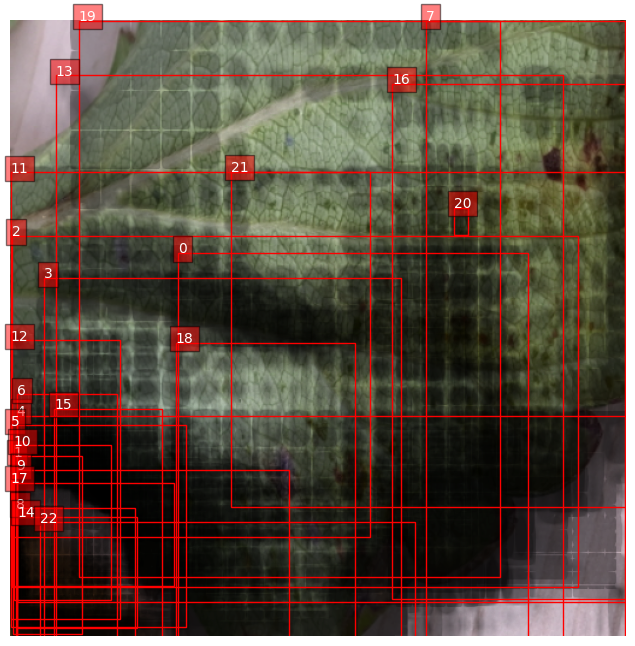

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

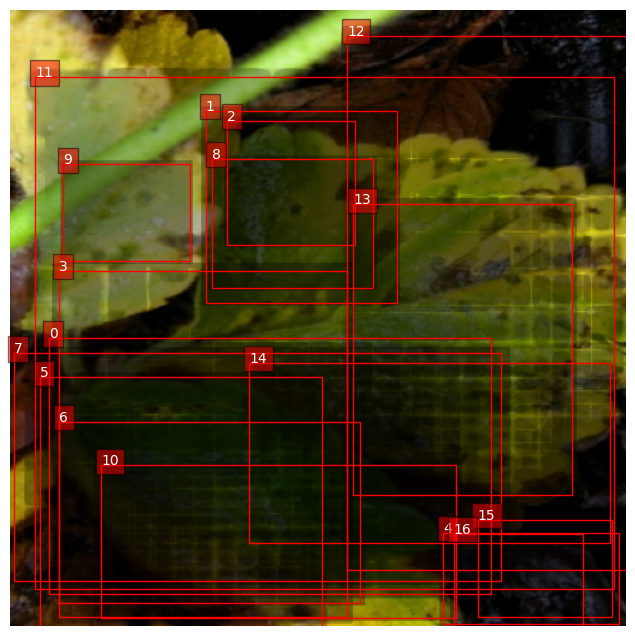

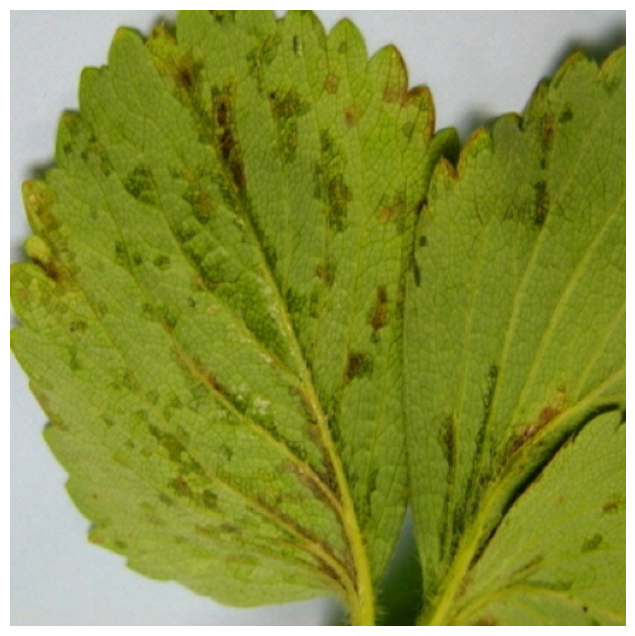

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

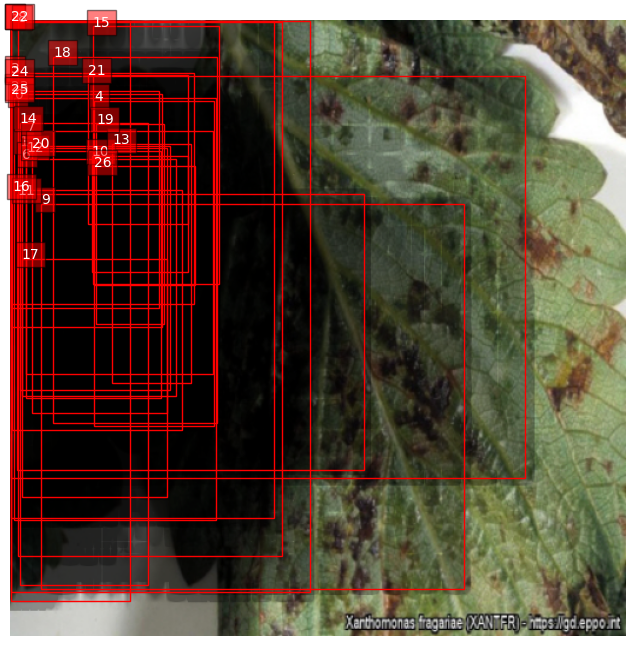

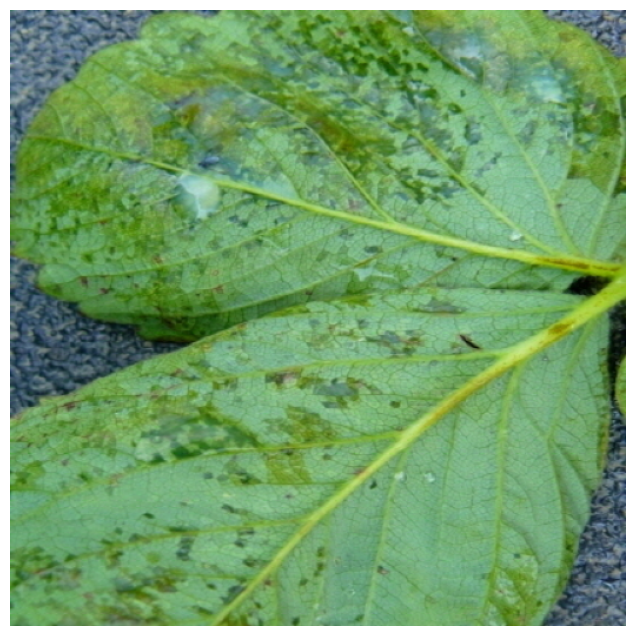

In [12]:
def visualize_prediction(image, prediction):
    image = image.permute(1,2,0).cpu().numpy()
    image = (image * 255).astype(np.uint8)  # Assuming input image is normalized in range [0, 1]
    masks = prediction['masks'].cpu().detach().numpy()
    boxes = prediction['boxes'].cpu().detach().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Show image
    ax.imshow(image)

    # Show masks and boxes
    for i in range(len(masks)):
        mask = masks[i].squeeze()
        if mask.ndim == 2:
            ax.imshow(np.dstack([np.zeros_like(mask)]*3 + [mask*255]), alpha=0.3)  # Making mask RGB + transparency, lower alpha
        box = boxes[i]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f"{i}", color='white', bbox=dict(facecolor='red', alpha=0.5))  # Displaying box indices

    plt.axis('off')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get some random images
for _ in range(5):
    idx = random.randint(0, len(train_data) - 1)
    img, _ = test_data[idx]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img)
    visualize_prediction(img[0], prediction[0])


In [24]:
all_predictions = []
all_targets = []

# Predict on the test set
with torch.no_grad():
    for images, targets in train_loader:
        images = [image for image in images]
        predictions = model(images)
        
        all_predictions.extend(predictions)
        all_targets.extend(targets)

# Calculate mAP
mAP = simple_mean_average_precision(all_targets, all_predictions)
print(f"mAP on test set: {mAP}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor